## Import's

In [48]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

## Считываем CSV

In [49]:
path = '../data/ab-test.csv'
df = pd.read_csv(path)

In [50]:
df.head()

,uid,diff,time,group
0,user_1,-103.333333,after,test
1,user_1,-6.000000,before,test
2,user_18,-10.000000,after,test
3,user_18,-3.500000,before,test
4,user_19,-82.333333,after,test


## Подключение к БД

In [51]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [52]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,pageviews
1,checker
2,deadlines


In [53]:
schema = pd.read_sql("PRAGMA table_info(checker);", conn)
schema

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,status,TEXT,0,None,0
2,2,success,INTEGER,0,None,0
3,3,timestamp,TIMESTAMP,0,None,0
4,4,numTrials,INTEGER,0,None,0
5,5,labname,TEXT,0,None,0
6,6,uid,TEXT,0,None,0


## Вытаскиваем число коммитов по checker, исключив project1

In [54]:
query = '''
SELECT uid, COUNT(*) as commits
FROM checker
WHERE uid LIKE 'user_%'
  AND labname NOT LIKE 'project1%'
GROUP BY uid
'''
commits = pd.read_sql(query, conn)
commits.head()


,uid,commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86


## Средняя разница между первым комитом и дедлайном

In [56]:
avg_diff = pd.read_sql('''
SELECT sub.uid,
       AVG( (JulianDay(sub.first_commit) -
             JulianDay(DATETIME(d.deadlines, 'unixepoch'))) * 24
       ) AS avg_diff
FROM (
    SELECT uid, labname, MIN(timestamp) AS first_commit
    FROM checker
    WHERE uid LIKE 'user_%'
      AND labname NOT LIKE 'project1%'
    GROUP BY uid, labname
) AS sub
LEFT JOIN deadlines AS d ON sub.labname = d.labs
GROUP BY sub.uid
''', conn)

avg_diff.head()

,uid,avg_diff
0,user_0,NaN
1,user_1,-65.119644
2,user_10,-75.242310
3,user_11,-2.884175
4,user_12,-89.450688


## Вытаскиваем число pageviews из таблицы pageviews

In [57]:
pageviews = pd.read_sql('''
SELECT uid, COUNT(*) as pageviews
FROM pageviews
WHERE uid LIKE 'user_%'
GROUP BY uid
''', conn)
pageviews.head()

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3


## Соединяем даные

In [58]:
merged = avg_diff.merge(pageviews, on='uid', how='inner') \
                 .merge(commits, on='uid', how='inner')


In [59]:
merged

,uid,avg_diff,pageviews,commits
0,user_1,-65.119644,28,62
1,user_10,-75.242310,89,20
2,user_14,-159.568696,143,61
3,user_17,-62.207513,47,51
4,user_18,-6.367907,3,5
5,user_19,-99.440298,16,118
6,user_21,-96.111041,10,65
7,user_25,-93.474751,179,79
8,user_28,-86.793652,149,60
9,user_3,-105.738041,317,18


## Построение графика

<Figure size 1500x800 with 0 Axes>

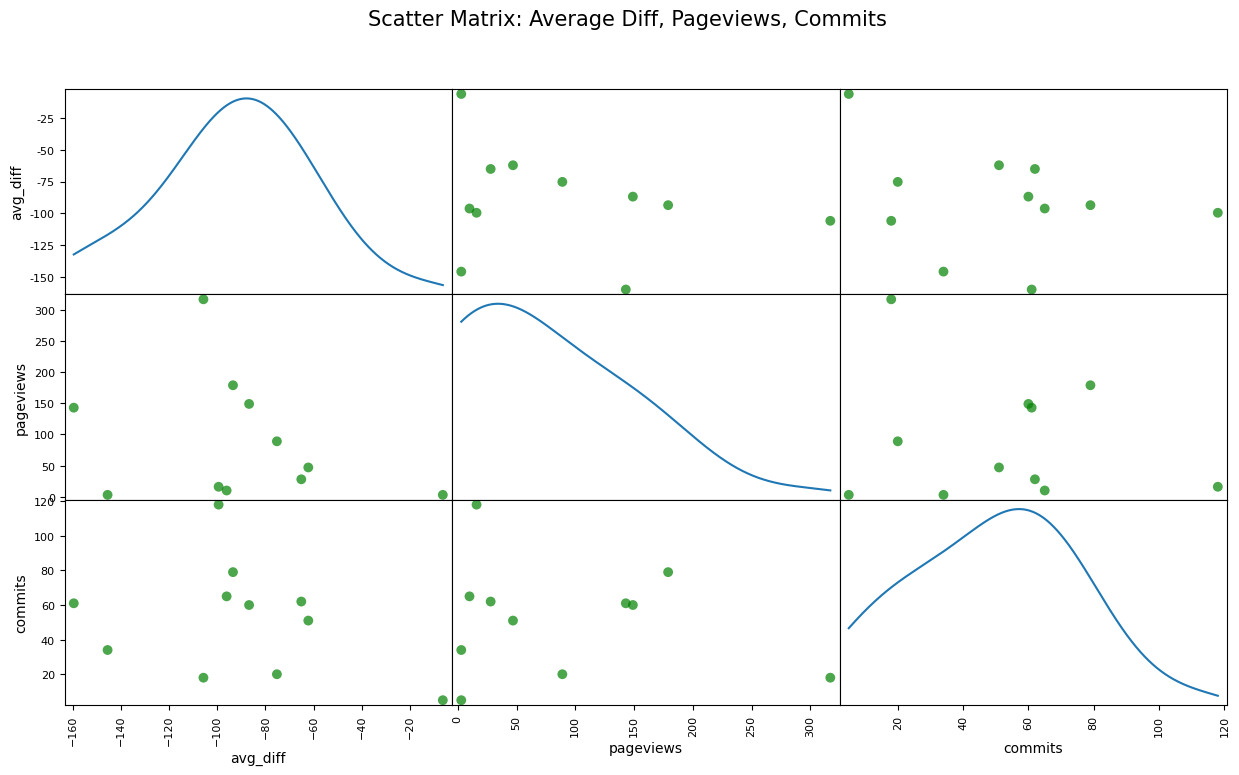

In [60]:
plt.figure(figsize=(15, 8))
scatter_matrix(
    merged[['avg_diff', 'pageviews', 'commits']],
    figsize=(15, 8),
    diagonal='kde',
    alpha=0.7,
    color='green',
    s=200,
    linewidths=3
)
plt.suptitle("Scatter Matrix: Average Diff, Pageviews, Commits", fontsize=15)
plt.show()


## Закрываем соединение с БД

In [61]:
conn.close()

### Questions

**Can we say that if a user has a low number of pageviews then they likely have a low number of commits?**  
Ответ: Нет, зависимость от количества коммитов и просмотров отсутствет

**Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?**  
Ответ: Нет, связи между количеством просмотров и временем начала работы не видно.

**Can we say that there are many users with a low number of commits and a few with a high number of commits?**  
Ответ: Да, большинство пользователей имеют низкое число коммитов.

**Can we say that there are many users with a small average difference and a few with a large average difference?**  
Ответ: Нет, пользователи не делают коммиты близко к дедлайну.
